In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib


In [4]:
dogecoin = pd.read_parquet('../databases/dogecoin_pure.parquet')

# Preview the data
print(dogecoin.head())

                               Open      High       Low     Close     Volume
Date                                                                        
2022-09-18 00:00:00+00:00  0.062210  0.062210  0.057238  0.057520  265405124
2022-09-19 00:00:00+00:00  0.057519  0.058744  0.056180  0.058612  301268389
2022-09-20 00:00:00+00:00  0.058612  0.060262  0.057738  0.058417  294929293
2022-09-21 00:00:00+00:00  0.058423  0.060478  0.056378  0.057404  406017754
2022-09-22 00:00:00+00:00  0.057386  0.059838  0.056945  0.059599  241738855


In [5]:
# Train-test split (e.g., 80% train, 20% test)
train_size = int(len(dogecoin) * 0.8)
train, test = dogecoin.iloc[:train_size], dogecoin.iloc[train_size:]

In [6]:
# Fit an ARIMA model on the Close price of the training data
arima_model = ARIMA(train['Close'], order=(5, 1, 5))  # Adjust (p, d, q) as needed
arima_result = arima_model.fit()

# Get ARIMA predictions for both train and test sets
train_predictions = arima_result.predict(start=0, end=len(train)-1)
test_predictions = arima_result.forecast(steps=len(test))


c:\Users\mario\OneDrive\Documentos\GitHub\cryptoseer\src\notebook\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mario\OneDrive\Documentos\GitHub\cryptoseer\src\notebook\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mario\OneDrive\Documentos\GitHub\cryptoseer\src\notebook\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [7]:
# Calculate residuals for the training data
train_residuals = train['Close'] - train_predictions

# Calculate residuals for the test data
test_residuals = test['Close'] - test_predictions


In [8]:
# Scale all features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the scaler on the training data
scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

# Function to create sequences of data for LSTM
def create_sequences(data, residuals, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # All features
        y.append(residuals[i + time_step])  # Residuals as the target
    return np.array(X), np.array(y)

# Set time_step (sequence length)
time_step = 10

# Create training sequences for LSTM
X_train, y_train = create_sequences(scaled_train, train_residuals.values, time_step)

# Reshape the input for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))


In [10]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))  # Number of features as input
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))  # Output the residual prediction (univariate)

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data
lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.1694e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1234e-04 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7393e-05
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9225e-05 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3229e-05 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4898e-05 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7930e-05 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9371e-05
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4318e-05
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7218e-05 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8502e-05 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4616e-05
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1786e-05
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5402e-05
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

In [12]:
lstm_test_predictions = lstm_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


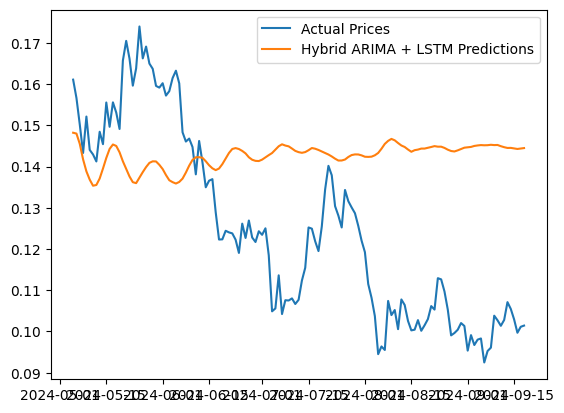

In [13]:
# ARIMA predictions for the test set (adjusting for time_step)
arima_test_predictions = test_predictions[time_step:]

# Combine ARIMA and LSTM residual predictions for the final prediction
hybrid_predictions = arima_test_predictions + lstm_test_predictions.flatten()

# Plot the results
plt.plot(test.index[time_step:], test['Close'][time_step:], label='Actual Prices')
plt.plot(test.index[time_step:], hybrid_predictions, label='Hybrid ARIMA + LSTM Predictions')
plt.legend()
plt.show()


In [19]:
mae_hybrid = mean_absolute_error(test['Close'][time_step:], hybrid_predictions)
mse_hybrid = mean_squared_error(test['Close'][time_step:], hybrid_predictions)
rmse_hybrid = np.sqrt(mse_hybrid)
r2_hybrid = r2_score(test['Close'][time_step:], hybrid_predictions)

# Print all the metrics
print(f'Mean Absolute Error (MAE): {mae_hybrid}')
print(f'Mean Squared Error (MSE): {mse_hybrid}')
print(f'Root Mean Squared Error (RMSE): {rmse_hybrid}')
print(f'R-squared (R²): {r2_hybrid}')

Mean Absolute Error (MAE): 0.026524900600267836
Mean Squared Error (MSE): 0.0009150324838985702
Root Mean Squared Error (RMSE): 0.030249503862023425
R-squared (R²): -0.7930946831950931


In [21]:
# Save the ARIMA model
arima_model_filename = '../models/arima_model.joblib'
joblib.dump(arima_result, arima_model_filename)
print(f"ARIMA model saved as {arima_model_filename}")

# Save the LSTM model
lstm_model_filename = '../models/lstm_model.h5'
lstm_model.save(lstm_model_filename)  # Keras models are saved with '.h5' format
print(f"LSTM model saved as {lstm_model_filename}")


ARIMA model saved as ../models/arima_model.joblib
LSTM model saved as ../models/lstm_model.h5
